### Loeading libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import math
import os

### Loading images to a list

In [2]:
# Loading images
imgs = []
labels = []
for img in glob.glob("./inputs/P1/*.png"):
    labels.append(" ".join(list(os.path.splitext(os.path.basename(img))[0].split("_"))).title())
    img = cv2.imread(img)
    if img.shape[1]%2!=0:
        img = np.delete(img,-1,1)
        
    imgs.append(img)

### a)

In [3]:
def immirror(img):
    # copy image that it does not apply change to ref image
    img = img.copy()
    #select col index from 0(right) to half of width: 
    #               *) in each step, swapping selected col with its reverse from the left(end of index)
    for col_index in range(img.shape[1]//2):
        for row_index in range(img.shape[0]):
            #swaping
            tmp = img[row_index,col_index,:].copy()
            img[row_index,col_index,:] = img[row_index,img.shape[1]-col_index-1,:]
            img[row_index,img.shape[1]-col_index-1,:] = tmp
    return img
   
        

### b)

In [4]:
 
def MirrorHandler(img:np.ndarray):
    left_mirror = immirror(img[:,0:img.shape[1]//2,:])
    right_mirror = immirror(img[:,img.shape[1]//2:,:])
    
    image_RL = img.copy()
    image_RL[:,0:right_mirror.shape[1],:] = right_mirror
    image_RL[:,right_mirror.shape[1]:,:] = left_mirror
    
    image_RR = np.zeros((right_mirror.shape[0],right_mirror.shape[1]*2,3),dtype=np.uint8)
    image_RR[:,image_RR.shape[1]//2:,:] = img[:,img.shape[1]//2:,:]
    image_RR[:,0:right_mirror.shape[1],:] = right_mirror
    
    image_LL = np.zeros((left_mirror.shape[0],left_mirror.shape[1]*2,3),dtype=np.uint8)
    image_LL[:,0:left_mirror.shape[1],:] = img[:,0:img.shape[1]//2,:]
    image_LL[:,left_mirror.shape[1]:,:] = left_mirror
    
    return img,image_RL,image_RR,image_LL


### c)

In [9]:

def impsnr(img,ref):
    img = img.astype(np.float64)
    ref = ref.astype(np.float64)

    mse = np.mean((ref - img) ** 2)
    if(mse == 0):  
        print("Images are same ...")              
        return 100
    max_pixel = 255
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

def imssim(_img,_ref):    
        
    SSIMs = []
    for channel in range(_img.shape[2]):
        ref = _ref[:,:,channel].astype(np.float64)
        img = _img[:,:,channel].astype(np.float64)
        
        normal_kernel = cv2.getGaussianKernel(11, 1.5)
        window = np.outer(normal_kernel, normal_kernel.transpose())

        mu_ref = cv2.filter2D(ref, -1, window)[5:-5, 5:-5] 
        mu_img = cv2.filter2D(img, -1, window)[5:-5, 5:-5]
        
        mu_ref_sq,  mu_img_sq = mu_ref**2,mu_img**2
        mu_ref_img = mu_ref * mu_img
        
        sigma_ref_sq = cv2.filter2D(ref**2, -1, window)[5:-5, 5:-5]
        sigma_ref_sq -= mu_ref_sq
        
        sigma_img_sq = cv2.filter2D(img**2, -1, window)[5:-5, 5:-5]
        sigma_img_sq -= mu_img_sq
        
        sigma_ref_img = cv2.filter2D(ref * img, -1, window)[5:-5, 5:-5] 
        sigma_ref_img -= mu_ref_img
        
        alpha = (0.01 * 255)**2
        beta = (0.03 * 255)**2
        ssim_map = ((2 * mu_ref_img + alpha) * (2 * sigma_ref_img + beta)) / ((mu_ref_sq + mu_img_sq + alpha) *
                                                                (sigma_ref_sq + sigma_img_sq + beta))
        SSIMs.append(ssim_map.mean())
    return np.array(SSIMs).mean()

### Generating results

Compare Results of PSNR:  14.86728766134457 14.86728766134457
Compare Results of PSNR:  17.75077640261459 17.75077640261459
Compare Results of PSNR:  19.897027253682925 19.897027253682925
Compare Results of PSNR:  12.594869682763346 12.594869682763346
Compare Results of PSNR:  16.794229633321716 16.794229633321716
Compare Results of PSNR:  20.81608920389835 20.81608920389835
Compare Results of PSNR:  16.923190730536117 16.923190730536117
Compare Results of PSNR:  17.388674197368154 17.388674197368154
Compare Results of PSNR:  17.31358201100402 17.31358201100402
Compare Results of PSNR:  16.69956724634557 16.69956724634557


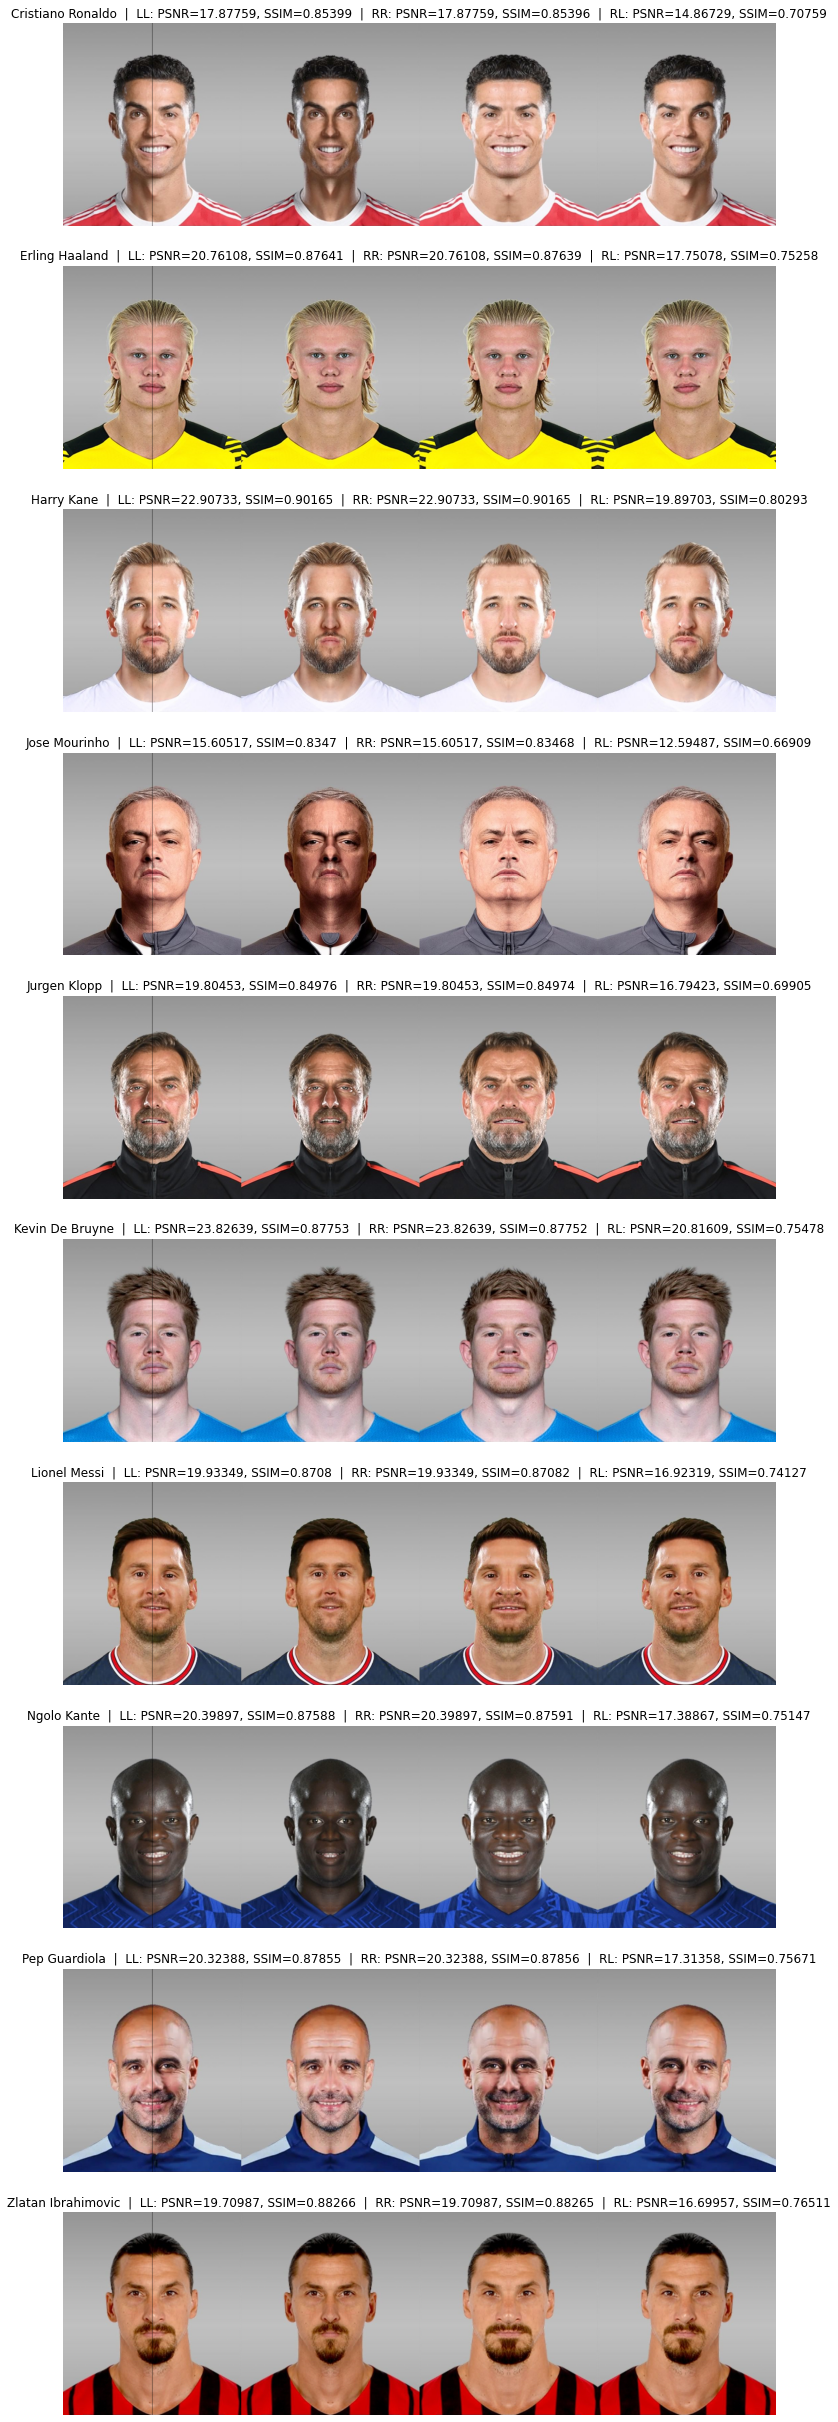

In [11]:
plt.rcParams["figure.figsize"] = (48,44)

plot_index = 1
for index in range(len(imgs)):
    imgs[index],rl,rr,ll = MirrorHandler(imgs[index])
    tmp = imgs[index].copy()
    tmp[:,imgs[index].shape[1]//2,:] = 0
    img_hor = cv2.hconcat([tmp,ll,rr,rl])
    cv2.imwrite("./outputs/P01/Out-{0}.png".format(labels[index]),img_hor)
    
    plt.subplot(10,1,plot_index)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img_hor, cv2.COLOR_BGR2RGB))
    plot_index += 1
    
    psnr_ll,ssim_ll = round(impsnr(ll,imgs[index]),5),round(imssim(ll,imgs[index]),5)
    psnr_rr,ssim_rr = round(impsnr(rr,imgs[index]),5),round(imssim(rr,imgs[index]),5)
    psnr_rl,ssim_rl = round(impsnr(rl,imgs[index]),5),round(imssim(rl,imgs[index]),5)
    print("Compare Results of PSNR: ",impsnr(rl,imgs[index]),cv2.PSNR(rl,imgs[index]))
    plt.title("{6}  |  LL: PSNR={0}, SSIM={1}  |  RR: PSNR={2}, SSIM={3}  |  RL: PSNR={4}, SSIM={5}".format(psnr_ll,ssim_ll,
                                                                                                   psnr_rr,ssim_rr,
                                                                                                   psnr_rl,ssim_rl,
                                                                                                   labels[index]))

plt.axis("off")
plt.show()
